### 5. Feature Engineering and Improvement

#### Task 5: Feature Engineering

Notebook: notebooks/Feature_Engineering.ipynb
Steps:

- Create new features that might improve model performance.
- Test different feature combinations.
- Evaluate the impact of new features on model performance.


Data loaded with shape: (213, 14)
New polynomial features added. Dataset shape: (213, 29)
Baseline Features - RMSE: 2.60 (std: 0.56)
Engineered Features - RMSE: 3.47 (std: 1.89)
Extended Polynomial Features - RMSE: 2.60 (std: 0.50)
Combined Extended Features - RMSE: 3.14 (std: 1.36)
Ridge Regression on Combined Extended Features
Test RMSE: 2.03     Test R-squared: 0.73

Random Forest on Combined Extended Features
Test RMSE: 2.17     Test R-squared: 0.69


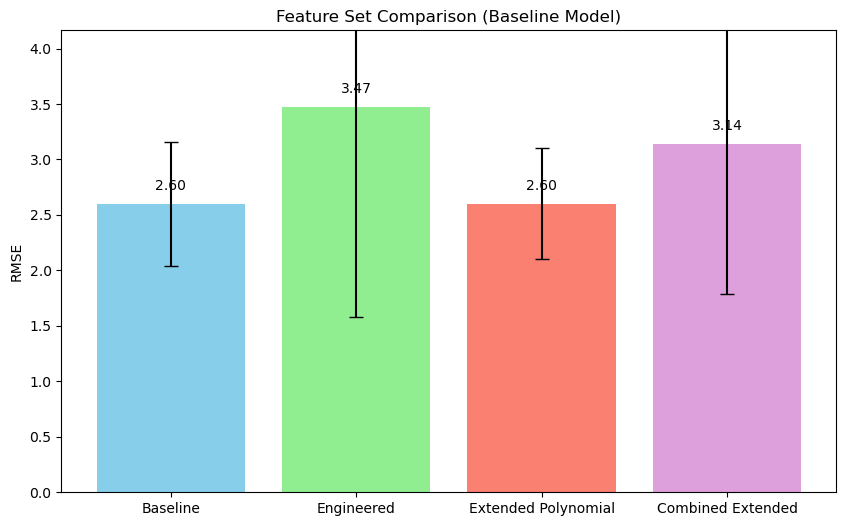

In [1]:
# Feature Engineering and Model Improvement
# Create new features that might improve model performance.
# - Experiment with additional feature combinations.
# - Generate polynomial combinations and interaction terms.
# - Test the impact of these new features on model performance with both a      baseline linear regression model and more sophisticated models.
#
# By exploring various engineered feature sets, we aim to understand how these modifications affect our predictive accuracy.

# Import necessary libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import PolynomialFeatures
import matplotlib.pyplot as plt
import seaborn as sns

# Load the preprocessed Boston Housing dataset.


data_file = "../data/processed_boston_housing.csv"  # Adjust path as needed
data = pd.read_csv(data_file)
print("Data loaded with shape:", data.shape)


# 2. Create and Experiment with New Features
# 
# Here we create several new features:
# 
# - **crim_indus**: Product of per capita crime rate (`crim`) and proportion of non-retail business acres (`indus`).
# - **rm_age_ratio**: Ratio of the average number of rooms (`rm`) to the proportion of older houses (`age`).
# - **lstat_sq**: Square of the lower status population (`lstat`), capturing non-linear effects.
# - **nox_rm**: Interaction of nitric oxide concentration (`nox`) and average number of rooms (`rm`).
# 
# Then, we experiment with additional interactions:
# 
# - **crim_rm**: Interaction between crime rate and number of rooms.
# - **tax_ptratio**: Product of property tax rate (`tax`) and pupil-teacher ratio (`ptratio`).


# Create our engineered features
data['crim_indus'] = data['crim'] * data['indus']
data['rm_age_ratio'] = data['rm'] / (data['age'] + 0.001)  # Avoid division by zero
data['lstat_sq'] = data['lstat'] ** 2
data['nox_rm'] = data['nox'] * data['rm']

# Additional interactions
data['crim_rm'] = data['crim'] * data['rm']
data['tax_ptratio'] = data['tax'] * data['ptratio']


# 3. Generate Polynomial and Interaction Terms
# 
# We use `PolynomialFeatures` to generate additional quadratic and interaction features from the baseline feature set.
# 
# **Note:** Using a higher-degree polynomial can greatly increase the number of features. Here, we generate polynomial features (degree 2) for a subset of selected features.
# 
# Lets select a subset of features for polynomial expansion: `'rm'`, `'lstat'`, and `'nox'`.


# Define the features for polynomial expansion
poly_features = ['rm', 'lstat', 'nox']
poly_transformer = PolynomialFeatures(degree=2, include_bias=False)
poly_data = poly_transformer.fit_transform(data[poly_features])

# Create a DataFrame with the polynomial features
poly_feature_names = poly_transformer.get_feature_names_out(poly_features)
poly_df = pd.DataFrame(poly_data, columns=poly_feature_names, index=data.index)

# Append the new polynomial features to the dataset
data = pd.concat([data, poly_df], axis=1)
print("New polynomial features added. Dataset shape:", data.shape)


# 4. Define Feature Sets for Evaluation
# 
# We define several feature sets to compare:
# 
# - **Baseline:** The original Boston Housing features.
# - **Engineered:** Baseline plus the engineered features and additional interactions.
# - **Extended Polynomial:** Baseline plus the new polynomial expansion features.
# - **Combined Extended:** All features together.
# 
# The target variable is `medv`.


# Define original Boston Housing features
baseline_features = ['crim', 'zn', 'indus', 'chas', 'nox', 'rm', 
                     'age', 'dis', 'rad', 'tax', 'ptratio', 'b', 'lstat']

# Define engineered features (from steps 2)
engineered_features = ['crim_indus', 'rm_age_ratio', 'lstat_sq', 'nox_rm', 
                       'crim_rm', 'tax_ptratio']

# Define polynomial features we generated (exclude the original ones in poly_features)
# We include all polynomial features for now.
poly_feature_list = list(poly_df.columns)

# Define the feature sets
features_baseline = baseline_features.copy()
features_engineered = baseline_features + engineered_features
features_poly = baseline_features + poly_feature_list
features_combined = baseline_features + engineered_features + poly_feature_list

target_column = 'medv'


# 5. Evaluation Helper Function
# 
# We create a helper function to evaluate a feature set using cross-validated RMSE for a chosen model and return the performance.
# 

def evaluate_feature_set(features, target, data, model, cv=5):
    """
    Evaluate a set of features with the given model using cross-validated RMSE.
    
    Parameters:
      - features: list of feature names
      - target: target column name
      - data: DataFrame
      - model: model instance (e.g., LinearRegression())
      - cv: number of cross-validation folds
      
    Returns:
      - mean_rmse: Average RMSE across folds
      - std_rmse: Standard deviation of RMSE
    """
    X = data[features]
    y = data[target]
    scores = cross_val_score(model, X, y, scoring='neg_mean_squared_error', cv=cv)
    rmse_scores = np.sqrt(-scores)
    return np.mean(rmse_scores), np.std(rmse_scores)


# 6. Compare Feature Sets with a Baseline Model
# 
# We start by comparing the different feature sets using a linear regression model as a baseline.

baseline_model = LinearRegression()

results = {}
for name, feat_set in [
    ("Baseline", features_baseline),
    ("Engineered", features_engineered),
    ("Extended Polynomial", features_poly),
    ("Combined Extended", features_combined)
]:
    mean_rmse, std_rmse = evaluate_feature_set(feat_set, target_column, data, baseline_model)
    results[name] = (mean_rmse, std_rmse)
    print(f"{name} Features - RMSE: {mean_rmse:.2f} (std: {std_rmse:.2f})")

# 7. Testing with More Sophisticated Models
# 
# In addition to the simple linear regression model, we test the impact of these feature sets using:
# 
# - **Ridge Regression** (a regularized linear model)
# - **Random Forest Regressor** (a non-linear ensemble model)
# 
# We use the "Combined Extended" feature set for demonstration.

# Prepare features from the Combined Extended set
combined_features = features_combined
X = data[combined_features]
y = data[target_column]

# Split the dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Ridge Regression
ridge_model = Ridge(alpha=1.0)
ridge_model.fit(X_train, y_train)
ridge_pred = ridge_model.predict(X_test)
ridge_rmse = np.sqrt(mean_squared_error(y_test, ridge_pred))
ridge_r2 = r2_score(y_test, ridge_pred)
print("Ridge Regression on Combined Extended Features")
print(f"Test RMSE: {ridge_rmse:.2f}     Test R-squared: {ridge_r2:.2f}")

# Random Forest Regressor
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)
rf_pred = rf_model.predict(X_test)
rf_rmse = np.sqrt(mean_squared_error(y_test, rf_pred))
rf_r2 = r2_score(y_test, rf_pred)
print("\nRandom Forest on Combined Extended Features")
print(f"Test RMSE: {rf_rmse:.2f}     Test R-squared: {rf_r2:.2f}")


# 8. Visual Comparison of Feature Set Evaluations
# 
# Let’s visualize the RMSE for each feature set from our baseline model evaluation.
# 

categories = list(results.keys())
rmse_values = [results[cat][0] for cat in categories]
std_values = [results[cat][1] for cat in categories]

plt.figure(figsize=(10, 6))
bars = plt.bar(categories, rmse_values, yerr=std_values, capsize=5, 
       color=["skyblue", "lightgreen", "salmon", "plum"])
plt.ylabel("RMSE")
plt.title("Feature Set Comparison (Baseline Model)")
plt.ylim(0, max(rmse_values) * 1.2)

# Annotate bars
for bar, rmse in zip(bars, rmse_values):
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2.0, yval + 0.1, f"{rmse:.2f}", ha='center', va='bottom')
    
plt.show()


# 9. Conclusions
# 
# Throughout this notebook, we have:
# 
# - Experimented with additional feature combinations and interaction terms.
# - Extended our feature set using polynomial transformations.
# - Evaluated the impact of these features using a baseline linear regression model and more sophisticated models like Ridge and Random Forest.
# 
# **Next Steps:**
# 
# - Further optimize models and explore hyperparameter tuning for improved performance.
# - Analyze feature importance from non-linear models (e.g., Random Forest) to guide further feature engineering.
# - Consider using other transformation techniques (e.g., logarithmic or exponential transformations) for skewed features.
# 
# This integrative approach can help us better understand which features and modeling strategies yield the best predictive outcomes.
